<a href="https://colab.research.google.com/github/EfekanMutlu/Classifications_with_Pytorch/blob/main/One_Label_Binary_Class/Astroseismology_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Binary Classification Example with Pytorch: RGB-HeB classification in Asteroseismology**
by *Efekan Mutlu*

In this project, we have an asteroseismological data set. Using this data, I will perform the binary classification. This classification can be done in many different ways, but here I will use a binary-classification model using Pytorch. In this project, we will first review our dataset, then visualize the data for better analysis, and finally, build a neural network using Pytorch and test its efficiency.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import metrics

In [ ]:

file="classification_in_asteroseismology.csv"
df=pd.read_csv(file)
df

,POP,Dnu,numax,epsilon
0,1,4.44780,43.06289,0.985
1,0,6.94399,74.07646,0.150
2,1,2.64571,21.57891,0.855
3,1,4.24168,32.13189,0.840
4,0,10.44719,120.37356,0.275
...,...,...,...,...
996,0,5.51582,49.99920,0.060
997,1,4.14823,32.09069,0.930
998,1,3.98294,30.90257,0.880
999,1,4.33893,45.62183,0.975


*Asteroseismology* is a branch of science that is used to study the vibrations of stars. These three columns represent important concepts used in asteroseismology to understand the vibrations of stars.

1. **Dnu:** The vibrations of stars are defined as modes with a specific degree and 
order. This column represents the average large frequency range between modes of the same degree and order. This is a measure that reflects the internal structure or size of the star.

2. **numax:** This column represents the maximum frequency of the star's vibration power. This value indicates how deeply the internal structure of the star is investigated and which regions are active.

3. **epsilon:** This value indicates how homogeneous the internal structure of the star is and which regions are more irregular.

4. **0 *as* RGB (Red Giant Branch):** It is the stage where the star has exhausted its hydrogen fuel and has begun burning helium.

5. **1 *as* HeB (Helium Burning):** It is the helium burning stage and occurs at the end of the star's life.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POP      1001 non-null   int64  
 1   Dnu      1001 non-null   float64
 2   numax    1001 non-null   float64
 3   epsilon  1001 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


In [ ]:
df.describe()

,POP,Dnu,numax,epsilon
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.712288,5.774810,58.441771,0.610774
std,0.452923,2.998103,43.425561,0.342518
min,0.000000,2.500080,17.979780,0.005000
25%,0.000000,4.073160,32.924350,0.220000
50%,1.000000,4.308740,38.293160,0.815000
75%,1.000000,6.580340,70.140830,0.890000
max,1.000000,17.699430,239.648480,1.000000


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


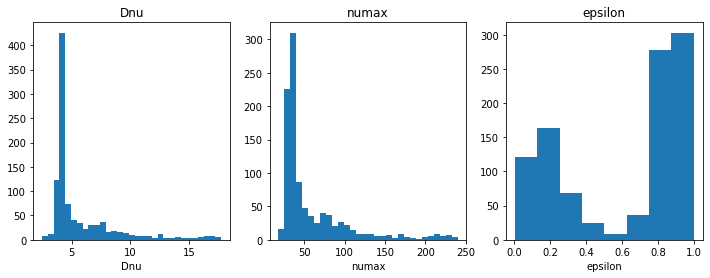

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(df["Dnu"], ax=ax[0], kde=False, hist_kws={"alpha": 1}, label="Dnu")
ax[0].set_title("Dnu")
sns.distplot(df["numax"], ax=ax[1], kde=False, hist_kws={"alpha": 1}, label="numax")
ax[1].set_title("numax")
sns.distplot(df["epsilon"], ax=ax[2], kde=False, hist_kws={"alpha": 1}, label="epsilon")
ax[2].set_title("epsilon")
plt.show()

If we look at the **Dnu** and **numax** histograms, we can see that the distributions of these two variables are very similar to each other, with the only striking difference being their amplitudes. The most striking point is the **epsilon** histogram. Having a valley appearance and having two sharp edges, it will make our work easier and increase the efficiency independently of the NN architecture when doing binary classification.

Having three variables creates a nice opportunity for us to create a 3D scatter plot. Using the plotly.express library, you can use the mouse to examine the relationship between these three variables more closely, thus understanding the relationship between them better.

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='Dnu', y='numax', z='epsilon', color='POP', 
                   title='Astroseismology Variables',labels={'Dnu':'Dnu','numax':'Numax','epsilon':'Epsilon','POP':'POP'})
fig.update_traces(marker_size = 2)
fig.show()

As clearly seen in the interactive figure above, **Dnu** and **numax** data have a linear relationship with each other. The part that will be most useful to us in classification is the **epsilon** axis. While the **RGB** class increases linearly according to epsilon, the **HeB** class is mostly clustered in values where epsilon is high. Of course, both classes are together in the lower parts of epsilon, but the **RGB** class is distributed in a tight linear line and the **HeB** data is spread over a wider area, which will make our classification easier. Additionally, this pattern we described and also the very few exceptions also increase the efficiency of our model significantly.

In [ ]:
y=df["POP"] #Preparing targets for the model
y 

0       1
1       0
2       1
3       1
4       0
       ..
996     0
997     1
998     1
999     1
1000    1
Name: POP, Length: 1001, dtype: int64

In [ ]:
x = df.iloc[:, 1:] #assigning the remaining 3 columns as variables
x

,Dnu,numax,epsilon
0,4.44780,43.06289,0.985
1,6.94399,74.07646,0.150
2,2.64571,21.57891,0.855
3,4.24168,32.13189,0.840
4,10.44719,120.37356,0.275
...,...,...,...
996,5.51582,49.99920,0.060
997,4.14823,32.09069,0.930
998,3.98294,30.90257,0.880
999,4.33893,45.62183,0.975


In [ ]:
# First, our data is divided into train+val - test
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=64)

# "then, the train and validation data are also divided among themselves
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

In [ ]:
scaler = MinMaxScaler()
#preparing the divided data for scaling.
#I used numpy to avoid various long and float errors in the future. Also it's faster
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [ ]:
#preparing mini batches
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))

train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(BinaryClassification,self).__init__()
        #Since my neural network is of linear type, I used the Sequential command. 
        #I used dropout and batch normalization to reduce overfitting
        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, num_class),
            nn.Softmax(dim=1) )

    def forward(self, x):
        return self.model(x)

In [ ]:
#The following function will be used to calculate accuracy in train operation
def acc(y_pred, y_test):
      y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
      _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
      correct = torch.eq(y_test, y_pred_tags).sum().item()
      acc = (correct / len(y_pred)) * 100 
      return acc

def train(model,epochs,optimizer,train_loader,val_loader,criterion,device,acc):
      accuracy_stats = {'train': [],"val": []}
      loss_stats = {'train': [],"val": []}#I will use a dictionary to monitor loss and accurancy changes more easily.
      for e in tqdm(range(1, epochs+1)):
        train_epoch_loss = 0
        train_epoch_acc = 0
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

            y_train_pred = model(X_train_batch)
       
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = acc(y_train_pred, y_train_batch)
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc

        with torch.no_grad():
          val_epoch_loss = 0
          val_epoch_acc = 0
          model.eval()

          for X_val_batch, y_val_batch in val_loader:
              X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

              y_val_pred = model(X_val_batch)

              val_loss = criterion(y_val_pred, y_val_batch)
              val_acc = acc(y_val_pred, y_val_batch)

              val_epoch_loss += val_loss.item()
              val_epoch_acc += val_acc
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
      return accuracy_stats, loss_stats

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = BinaryClassification(num_feature = len(x.columns), num_class=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

In [ ]:
print("Begin training.")
accuracy_stats,loss_stats=train(model,160,optimizer,train_loader,val_loader,criterion,device,acc)

Begin training.


  0%|          | 0/160 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

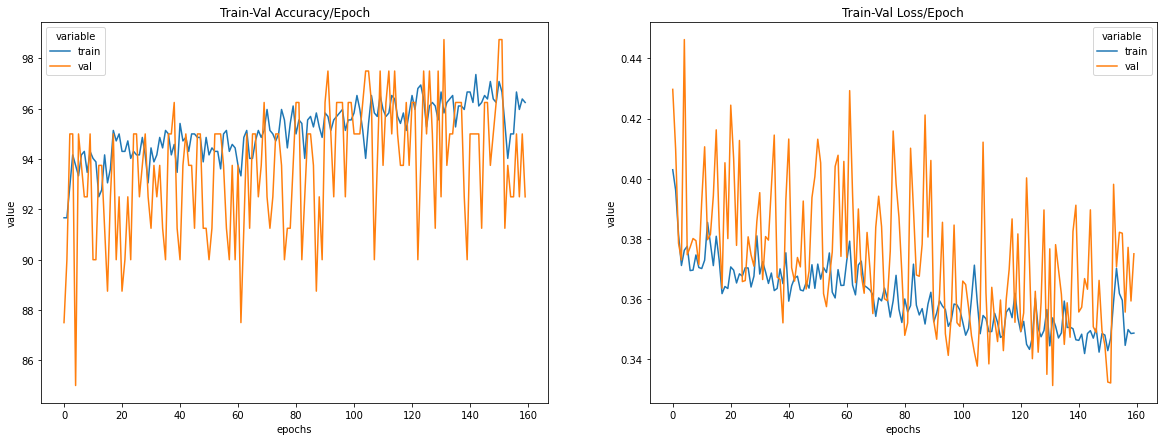

In [ ]:
# Plotting accuracy and loss for train and validation per epoch
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [ ]:
#testing
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = list(a.squeeze().tolist() for a in y_pred_list)

In [ ]:
#accuracy score
print(accuracy_score(y_test,y_pred_list))

0.9701492537313433


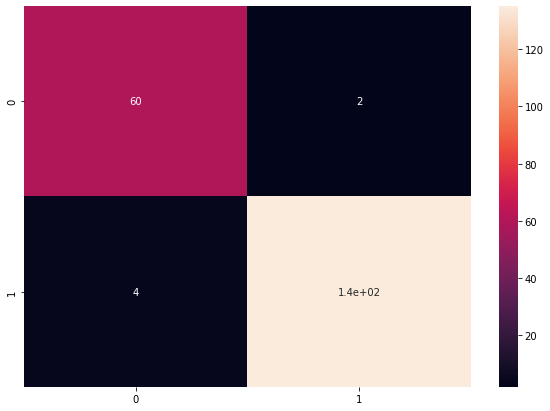

In [ ]:
#confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred_list) , annot=True)

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        62
           1       0.99      0.97      0.98       139

    accuracy                           0.97       201
   macro avg       0.96      0.97      0.97       201
weighted avg       0.97      0.97      0.97       201



"Although the loss & accuracy graphs of the train and validation values are daunting, the concentration on the diagonal of the confusion matrix shows that our model is very efficient.  Only 5 predictions were misclassified, while the remaining 200 predictions were correct. These results can be seen numerically in the classification report. Precision, recall and hence f1 score are almost at their maximum. The most important reason for this is, as I mentioned earlier, that astroseismological data is already very suitable for binary classification. Additionally, the methods I used to prevent overfitting have also contributed to this performance.

*Thank you for taking the time.*